# Green House Gas Emissions
In this notebook we will predict GHG-emissions based on social and governance readiness scores with inspiration from ND-GAIN indicators. 

Overview of the notebook structure
- Cleaning and assessing GHG-emission data 
- Log-transforming GHG data
- Combining GHG data with Predictor data
- Exploring correlations with the predictor data 
- Splitting the combined dataset in training, validation and testing data
    - With our outcome variable (GHG) lagged by 5 years
- Fitting baseline model (mean model)
- Fitting simple mixed effects model (time, population, countrysize)
- Fitting simple mixed effects models with each predictor seperately (time, population, countrysize, predictor_xyzab)
- Fitting theory driven mixed effects model of social (time, population, countrysize, predictor_x, predictor_y, predictor_z)
- Fitting theory driven mixed effects model of governance (time, population, countrysize, predictor_x, predictor_y, predictor_z)
- Fitting a mixed effects decision tree model, random forest with all predictors
- Compare model predictions 


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import os

import pickle as pkl

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GroupShuffleSplit

# Cleaning and combining data 

In [3]:
#Read file 
df = pd.read_csv('Data/ghg-emissions.csv')

<bound method NDFrame.describe of              iso                                     Country/Region    unit  \
0            CHN                                              China  MtCO2e   
1            USA                                      United States  MtCO2e   
2            IND                                              India  MtCO2e   
3            RUS                                             Russia  MtCO2e   
4            IDN                                          Indonesia  MtCO2e   
..           ...                                                ...     ...   
190          TUV                                             Tuvalu  MtCO2e   
191          NIU                                               Niue  MtCO2e   
192          FJI                                               Fiji  MtCO2e   
193  Data source                                      Climate Watch     NaN   
194     Data for  Location: World. Sectors/Subsectors: Total inc...     NaN   

        1990     

In [4]:
#clean data 
df.drop([193, 194], inplace=True)

melted_df = pd.melt(df, id_vars=['iso', 'Country/Region', 'unit'], var_name='Year', value_name='ghg')

#print(melted_df)

In [5]:
melted_df.describe()

,iso,Country/Region,unit,Year,ghg
count,5983,5983,5983,5983,5983.00
unique,193,193,1,31,4569.00
top,CHN,China,MtCO2e,1990,0.02
freq,31,31,5983,193,29.00


In [6]:
melted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5983 entries, 0 to 5982
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   iso             5983 non-null   object
 1   Country/Region  5983 non-null   object
 2   unit            5983 non-null   object
 3   Year            5983 non-null   object
 4   ghg             5983 non-null   object
dtypes: object(5)
memory usage: 233.8+ KB


In [7]:
melted_df.replace('false', np.nan, inplace=True)
melted_df['Year'] = melted_df['Year'].astype(float)
melted_df['ghg'] = melted_df['ghg'].astype(float)

In [8]:

melted_df.dropna()
print(melted_df)

      iso Country/Region    unit    Year      ghg
0     CHN          China  MtCO2e  1990.0  2892.41
1     USA  United States  MtCO2e  1990.0  5448.74
2     IND          India  MtCO2e  1990.0  1020.11
3     RUS         Russia  MtCO2e  1990.0  2624.74
4     IDN      Indonesia  MtCO2e  1990.0  1140.84
...   ...            ...     ...     ...      ...
5978  COK   Cook Islands  MtCO2e  2020.0     0.07
5979  NRU          Nauru  MtCO2e  2020.0     0.05
5980  TUV         Tuvalu  MtCO2e  2020.0     0.02
5981  NIU           Niue  MtCO2e  2020.0     0.00
5982  FJI           Fiji  MtCO2e  2020.0    -0.81

[5983 rows x 5 columns]


KeyboardInterrupt: 

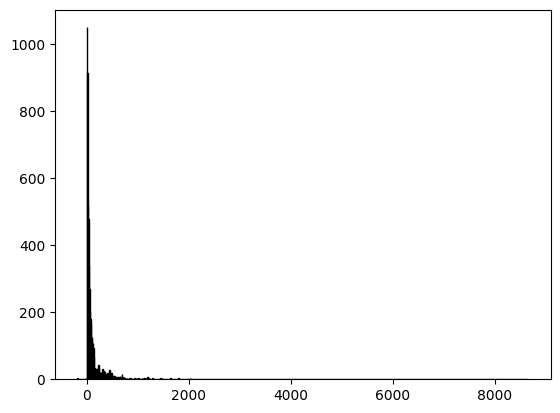

In [9]:
sns.histplot(data=melted_df, x='ghg', binwidth=10)
plt.show()

We need to transform our variable, so that the most polluting countries don't weigh to much. 

In [ ]:
#Making a list for all countries that have exactly 0.0 percent ghg. 

zero_countries = melted_df.groupby('iso')['ghg'].sum()

zero_countries = zero_countries[zero_countries == 0.0].index.tolist()

print(zero_countries)

[]


Removing NIU, becuase it contains 0 values of GHG. 

In [ ]:
#Defining the country to remove
countries_to_remove = ['NIU'] 

#Filtering the DataFrame to remove the specified countries
melted_df = melted_df[~melted_df['iso'].isin(countries_to_remove)]

In [ ]:
#Log transform
melted_df['log_ghg'] = np.log(melted_df['ghg'])

# Check the result
print(melted_df.head())




   iso Country/Region    unit    Year      ghg   log_ghg
0  CHN          China  MtCO2e  1990.0  2892.41  7.969845
1  USA  United States  MtCO2e  1990.0  5448.74  8.603140
2  IND          India  MtCO2e  1990.0  1020.11  6.927666
3  RUS         Russia  MtCO2e  1990.0  2624.74  7.872737
4  IDN      Indonesia  MtCO2e  1990.0  1140.84  7.039520


c:\Users\mlj\OneDrive - Aarhus Universitet\MA 2. Semester\Data Science\DataScienceExam\data_sci_env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


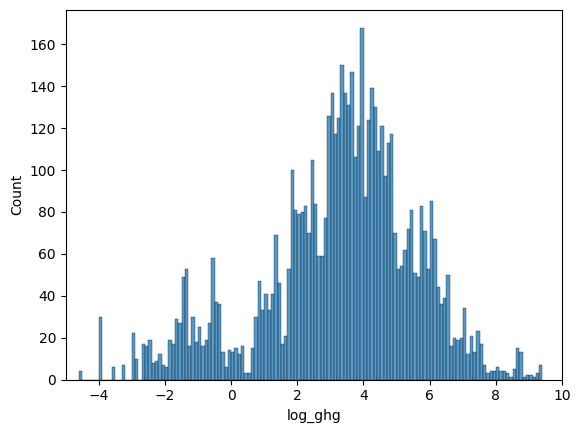

In [ ]:
sns.histplot(data=melted_df, x='log_ghg', binwidth=0.1)
# Setting x-axis limit
plt.xlim(left=-5)
plt.xlim(right=10)
plt.show()

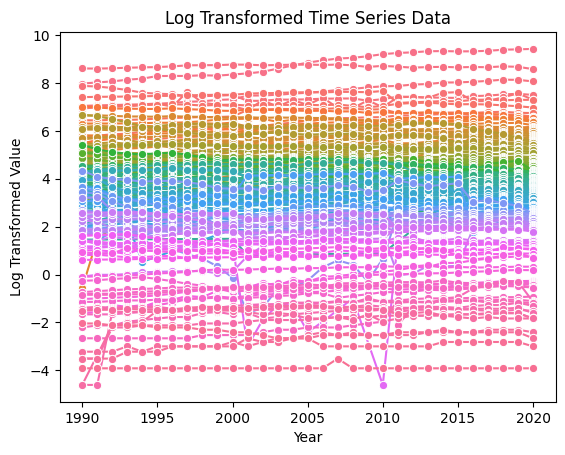

In [ ]:
sns.lineplot(data=melted_df, x='Year', y='log_ghg', hue='iso', marker='o', legend=False)

# Add title and labels
plt.title('Log Transformed Time Series Data')
plt.xlabel('Year')
plt.ylabel('Log Transformed Value')

# Show the plot
plt.show()

In [11]:
print(melted_df.isna().sum())

iso               0
Country/Region    0
unit              0
Year              0
ghg               1
dtype: int64


In [ ]:
display(melted_df)

,iso,Country/Region,unit,Year,ghg,log_ghg
0,CHN,China,MtCO2e,1990.0,2892.41,7.969845
1,USA,United States,MtCO2e,1990.0,5448.74,8.603140
2,IND,India,MtCO2e,1990.0,1020.11,6.927666
3,RUS,Russia,MtCO2e,1990.0,2624.74,7.872737
4,IDN,Indonesia,MtCO2e,1990.0,1140.84,7.039520
...,...,...,...,...,...,...
5977,KIR,Kiribati,MtCO2e,2020.0,0.09,-2.407946
5978,COK,Cook Islands,MtCO2e,2020.0,0.07,-2.659260
5979,NRU,Nauru,MtCO2e,2020.0,0.05,-2.995732
5980,TUV,Tuvalu,MtCO2e,2020.0,0.02,-3.912023


### Add predictors to our GHG-dataset

In [ ]:
#Read predictor file 

pred = pd.read_excel('git_data/predictor_data.xlsx')

print(pred)

                      Country Name Country Code  Year  Population, total  \
0                            Aruba          ABW  1960            54608.0   
1      Africa Eastern and Southern          AFE  1960        130692579.0   
2                      Afghanistan          AFG  1960          8622466.0   
3       Africa Western and Central          AFW  1960         97256290.0   
4                           Angola          AGO  1960          5357195.0   
...                            ...          ...   ...                ...   
17113        São Tomé and Principe          STP  2022                NaN   
17114                      Türkiye          TUR  2022                NaN   
17115                Taiwan, China          TWN  2022                NaN   
17116                      Vietnam          VNM  2022                NaN   
17117      Jersey, Channel Islands          JEY  2022                NaN   

       Land area (sq. km)    WGI VA    WGI PS    WGI GE    WGI RQ    WGI RL  \
0       

In [ ]:
melted_df = melted_df.rename(columns={'iso': 'Country Code'})

print(melted_df)
display(melted_df)

     Country Code Country/Region    unit    Year      ghg   log_ghg
0             CHN          China  MtCO2e  1990.0  2892.41  7.969845
1             USA  United States  MtCO2e  1990.0  5448.74  8.603140
2             IND          India  MtCO2e  1990.0  1020.11  6.927666
3             RUS         Russia  MtCO2e  1990.0  2624.74  7.872737
4             IDN      Indonesia  MtCO2e  1990.0  1140.84  7.039520
...           ...            ...     ...     ...      ...       ...
5977          KIR       Kiribati  MtCO2e  2020.0     0.09 -2.407946
5978          COK   Cook Islands  MtCO2e  2020.0     0.07 -2.659260
5979          NRU          Nauru  MtCO2e  2020.0     0.05 -2.995732
5980          TUV         Tuvalu  MtCO2e  2020.0     0.02 -3.912023
5982          FJI           Fiji  MtCO2e  2020.0    -0.81       NaN

[5952 rows x 6 columns]


,Country Code,Country/Region,unit,Year,ghg,log_ghg
0,CHN,China,MtCO2e,1990.0,2892.41,7.969845
1,USA,United States,MtCO2e,1990.0,5448.74,8.603140
2,IND,India,MtCO2e,1990.0,1020.11,6.927666
3,RUS,Russia,MtCO2e,1990.0,2624.74,7.872737
4,IDN,Indonesia,MtCO2e,1990.0,1140.84,7.039520
...,...,...,...,...,...,...
5977,KIR,Kiribati,MtCO2e,2020.0,0.09,-2.407946
5978,COK,Cook Islands,MtCO2e,2020.0,0.07,-2.659260
5979,NRU,Nauru,MtCO2e,2020.0,0.05,-2.995732
5980,TUV,Tuvalu,MtCO2e,2020.0,0.02,-3.912023


In [ ]:
ghg_full = pd.merge(melted_df, pred, on = ['Year', 'Country Code'], how = 'inner')
ghg_full = ghg_full.drop(columns=['Country Name'])

print(ghg_full)
display(ghg_full)

     Country Code Country/Region    unit    Year      ghg   log_ghg  \
0             CHN          China  MtCO2e  1990.0  2892.41  7.969845   
1             USA  United States  MtCO2e  1990.0  5448.74  8.603140   
2             IND          India  MtCO2e  1990.0  1020.11  6.927666   
3             RUS         Russia  MtCO2e  1990.0  2624.74  7.872737   
4             IDN      Indonesia  MtCO2e  1990.0  1140.84  7.039520   
...           ...            ...     ...     ...      ...       ...   
6092          KIR       Kiribati  MtCO2e  2020.0     0.09 -2.407946   
6093          COK   Cook Islands  MtCO2e  2020.0     0.07 -2.659260   
6094          NRU          Nauru  MtCO2e  2020.0     0.05 -2.995732   
6095          TUV         Tuvalu  MtCO2e  2020.0     0.02 -3.912023   
6096          FJI           Fiji  MtCO2e  2020.0    -0.81       NaN   

      Population, total  Land area (sq. km)    WGI VA    WGI PS    WGI GE  \
0          1.135185e+09           9388250.0       NaN       NaN       

,Country Code,Country/Region,unit,Year,ghg,log_ghg,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,Education,Innovation,Social Inequality,ICT
0,CHN,China,MtCO2e,1990.0,2892.41,7.969845,1.135185e+09,9388250.0,NaN,NaN,NaN,NaN,NaN,NaN,3.001490,5832.0,8.3,NaN
1,USA,United States,MtCO2e,1990.0,5448.74,8.603140,2.496230e+08,9158960.0,NaN,NaN,NaN,NaN,NaN,NaN,69.676811,90643.0,5.6,NaN
2,IND,India,MtCO2e,1990.0,1020.11,6.927666,8.704522e+08,2973190.0,NaN,NaN,NaN,NaN,NaN,NaN,5.851950,1147.0,NaN,NaN
3,RUS,Russia,MtCO2e,1990.0,2624.74,7.872737,1.479694e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.920052,NaN,NaN,NaN
4,IDN,Indonesia,MtCO2e,1990.0,1140.84,7.039520,1.821599e+08,1811570.0,NaN,NaN,NaN,NaN,NaN,NaN,8.385050,NaN,8.8,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6092,KIR,Kiribati,MtCO2e,2020.0,0.09,-2.407946,1.264630e+05,810.0,1.115723,1.163733,0.135920,-0.430563,1.009464,0.467346,NaN,NaN,NaN,14.464986
6093,COK,Cook Islands,MtCO2e,2020.0,0.07,-2.659260,NaN,NaN,1.069792,1.151947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6094,NRU,Nauru,MtCO2e,2020.0,0.05,-2.995732,1.231500e+04,20.0,0.535820,0.776041,0.145207,-0.083868,-0.103150,0.599187,NaN,NaN,NaN,NaN
6095,TUV,Tuvalu,MtCO2e,2020.0,0.02,-3.912023,1.106900e+04,30.0,1.173426,1.218199,-0.430198,-0.317362,0.650381,0.484759,NaN,NaN,NaN,NaN


In [ ]:
ghg_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6097 entries, 0 to 6096
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Country Code        6097 non-null   object 
 1   Country/Region      6097 non-null   object 
 2   unit                6097 non-null   object 
 3   Year                6097 non-null   float64
 4   ghg                 6096 non-null   float64
 5   log_ghg             6011 non-null   float64
 6   Population, total   5921 non-null   float64
 7   Land area (sq. km)  5797 non-null   float64
 8   WGI VA              4109 non-null   float64
 9   WGI PS              4068 non-null   float64
 10  WGI GE              4033 non-null   float64
 11  WGI RQ              4036 non-null   float64
 12  WGI RL              4109 non-null   float64
 13  WGI CC              4052 non-null   float64
 14  Education           3635 non-null   float64
 15  Innovation          2994 non-null   float64
 16  Social

### Save combined data

In [ ]:
ghg_full.to_csv('GHG-modelling.csv', index=False)

# Modelling GHG data 


### Assessing data 

Our full GHG-dataset does contain a significant amount of Na's. Since the linear regression dont handle Na's well, we have decided to drop countries that contains Na's. This leave us with 102 countries for GHG analysis. 

In [131]:
ghg = pd.read_csv('git_data/GHG-modelling.csv')

In [129]:
ghg = ghg
indices_with_na = ghg[ghg['ghg'].isna()].index
print(indices_with_na)

ghg.loc[indices_with_na]

Index([120], dtype='int64')


,Country Code,Country/Region,unit,Year,ghg,log_ghg,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,Education,Innovation,Social Inequality,ICT,Health
120,NAM,Namibia,MtCO2e,1990.0,NaN,NaN,1369011.0,823290.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN


In [132]:
print(ghg.isna().sum())

Country Code             0
Country/Region           0
unit                     0
Year                     0
ghg                      1
log_ghg                 89
Population, total      830
Land area (sq. km)     954
WGI VA                2634
WGI PS                2678
WGI GE                2713
WGI RQ                2710
WGI RL                2637
WGI CC                2694
Education             3116
Innovation            3757
Social Inequality     4927
ICT                   3459
Health                1863
dtype: int64


In [125]:
ghg = ghg.drop(indices_with_na)

In [15]:
countries_without_nans = ghg_full.dropna(subset=ghg_full.columns, how='any')['Country Code'].unique()

len(countries_without_nans)

92

In [ ]:
ghg = ghg_full.drop(columns=['ICT', 'Innovation', 'Social Inequality'])

ghg = ghg.dropna()
print(ghg)

     Country Code Country/Region    unit    Year      ghg   log_ghg  \
1146          CHN          China  MtCO2e  1996.0  3982.98  8.289786   
1147          USA  United States  MtCO2e  1996.0  5933.25  8.688327   
1148          IND          India  MtCO2e  1996.0  1293.39  7.165022   
1149          RUS         Russia  MtCO2e  1996.0  1858.96  7.527772   
1150          IDN      Indonesia  MtCO2e  1996.0  1101.48  7.004410   
...           ...            ...     ...     ...      ...       ...   
6097          LCA    Saint Lucia  MtCO2e  2020.0     0.70 -0.356675   
6099          WSM          Samoa  MtCO2e  2020.0     0.65 -0.430783   
6105          BTN         Bhutan  MtCO2e  2020.0     0.32 -1.139434   
6107          TON          Tonga  MtCO2e  2020.0     0.27 -1.309333   
6112          LIE  Liechtenstein  MtCO2e  2020.0     0.16 -1.832581   

            Country Name  Population, total  Land area (sq. km)    WGI VA  \
1146               China       1.217550e+09           9388230.0 -1.361

In [ ]:
len(ghg['Country Code'].unique())

ghg.describe()

,Year,ghg,log_ghg,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,Education
count,2489.000000,2489.000000,2489.000000,2.489000e+03,2.489000e+03,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000
mean,2009.814383,271.946521,3.860720,4.784768e+07,7.885110e+05,-0.004453,-0.062692,0.095947,0.107788,0.022567,0.023053,37.179017
std,6.598568,988.029077,1.879223,1.703566e+08,2.073008e+06,0.990443,0.934334,0.942266,0.932814,0.965679,0.997672,27.570889
min,1996.000000,0.010000,-4.605170,1.780500e+04,1.600000e+02,-2.259164,-3.180352,-2.336034,-2.273735,-1.992472,-1.759068,0.212510
25%,2005.000000,15.130000,2.716680,3.310202e+06,4.000000e+04,-0.813358,-0.684062,-0.640733,-0.551774,-0.733363,-0.740643,12.372820
50%,2010.000000,44.220000,3.789177,9.613503e+06,1.750200e+05,0.001791,-0.016168,-0.079239,-0.021728,-0.203318,-0.258609,32.847256
75%,2015.000000,153.960000,5.036693,3.043190e+07,5.691400e+05,0.886210,0.679096,0.777293,0.861490,0.767495,0.658825,58.643349
max,2020.000000,12295.620000,9.416998,1.411100e+09,1.638139e+07,1.800992,1.758681,2.347191,2.205299,2.124782,2.459118,143.310684


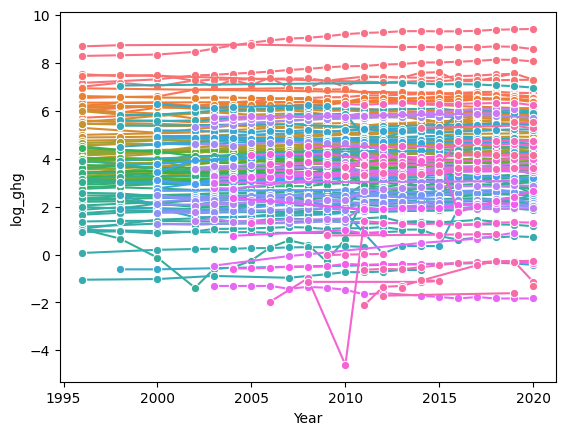

In [ ]:
sns.lineplot(data=ghg, x='Year', y='log_ghg', hue='Country Code', marker='o', legend=False)

# Add title and labels
#plt.title('Log Transformed Time Series Data')
#plt.xlabel('Year')
#plt.ylabel('Log Transformed Value')

# Show the plot
plt.show()

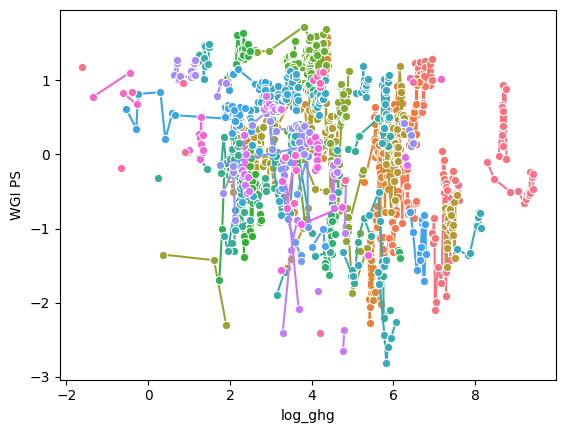

In [ ]:
sns.lineplot(data=ghg, x='log_ghg', y='WGI PS', hue='Country Code', marker='o', legend=False)

# Add title and labels
#plt.title('Log Transformed Time Series Data')
#plt.xlabel('Year')
#plt.ylabel('Log Transformed Value')

# Show the plot
plt.show()

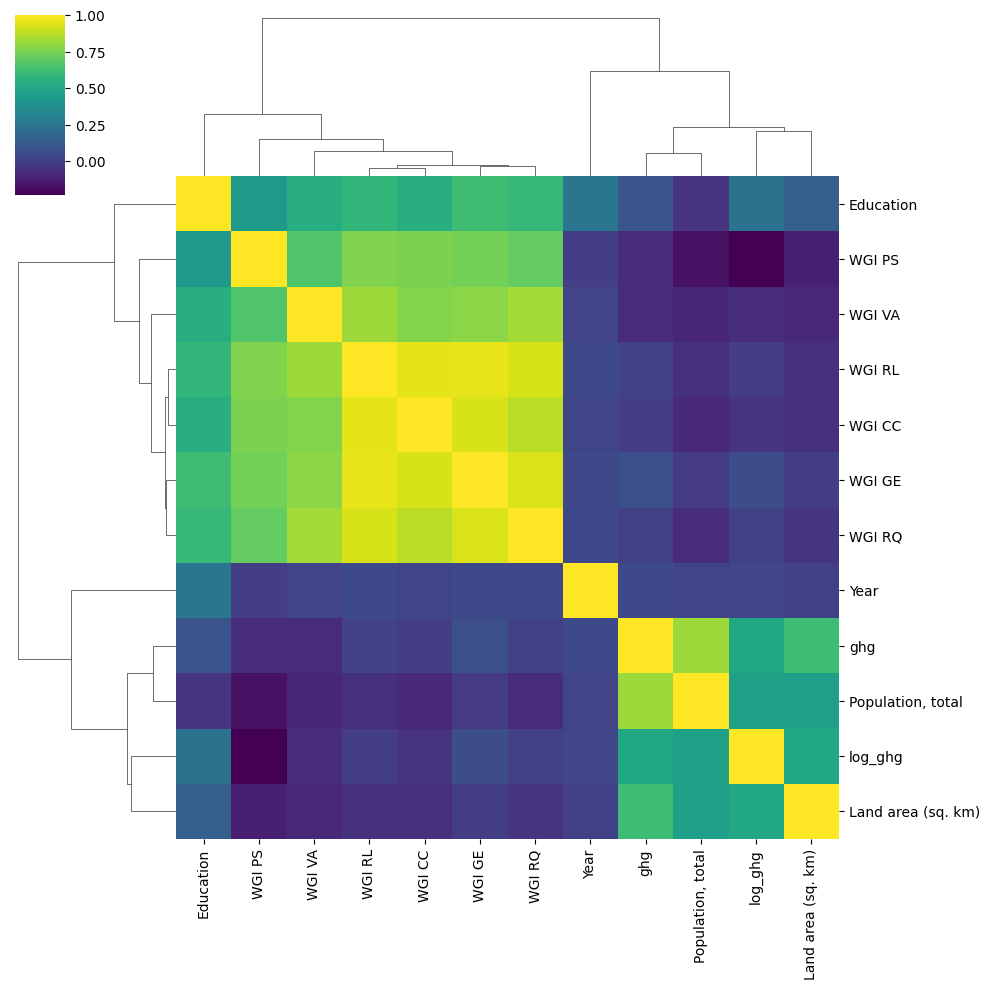

In [ ]:
ghg_num = ghg[ghg.select_dtypes(exclude=['object']).columns]

sns.clustermap(ghg_num.corr(), cmap='viridis')
plt.show()

## Splitting the data set

Splitting the dataset into 70% training, 15% validation, 15% set. Then the Y variable must be lagged 4 years (not 5 to accomodate for the datastructure of 1996, 1998, 2000, 2002-2020). 

In [110]:
ghg = ghg_full

display(ghg)

,Country Code,Country/Region,unit,Year,ghg,log_ghg,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,Education,Innovation,Social Inequality,ICT,Health
0,CHN,China,MtCO2e,1990.0,2892.41,7.969845,1.135185e+09,9388250.0,NaN,NaN,NaN,NaN,NaN,NaN,3.001490,5832.0,8.3,NaN,NaN
1,USA,United States,MtCO2e,1990.0,5448.74,8.603140,2.496230e+08,9158960.0,NaN,NaN,NaN,NaN,NaN,NaN,69.676811,90643.0,5.6,NaN,NaN
2,IND,India,MtCO2e,1990.0,1020.11,6.927666,8.704522e+08,2973190.0,NaN,NaN,NaN,NaN,NaN,NaN,5.851950,1147.0,NaN,NaN,NaN
3,RUS,Russia,MtCO2e,1990.0,2624.74,7.872737,1.479694e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.920052,NaN,NaN,NaN,NaN
4,IDN,Indonesia,MtCO2e,1990.0,1140.84,7.039520,1.821599e+08,1811570.0,NaN,NaN,NaN,NaN,NaN,NaN,8.385050,NaN,8.8,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6746,COK,Cook Islands,MtCO2e,2020.0,0.07,-2.659260,NaN,NaN,1.069792,1.151947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6747,NRU,Nauru,MtCO2e,2020.0,0.05,-2.995732,1.231500e+04,20.0,0.535820,0.776041,0.145207,-0.083868,-0.103150,0.599187,NaN,NaN,NaN,NaN,0.553662
6748,TUV,Tuvalu,MtCO2e,2020.0,0.02,-3.912023,1.106900e+04,30.0,1.173426,1.218199,-0.430198,-0.317362,0.650381,0.484759,NaN,NaN,NaN,NaN,0.605705
6749,NIU,Niue,MtCO2e,2020.0,0.00,-46.051702,NaN,NaN,1.267860,1.362529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [120]:
ghg.isna().sum()

Country Code             0
Country/Region           0
unit                     0
Year                     0
ghg                      0
log_ghg                 88
Population, total      830
Land area (sq. km)     954
WGI VA                2633
WGI PS                2677
WGI GE                2712
WGI RQ                2709
WGI RL                2636
WGI CC                2693
Education             3115
Innovation            3757
Social Inequality     4926
ICT                   3458
Health                1862
dtype: int64

In [121]:
#Defining the number of years to lag
lag_years = 4

#Creating the new column 'Lagged_ghg' and initializing with NaN
ghg['lagged_ghg'] = pd.NA

#Iterating over each row
for i in range(len(ghg)):
    country = ghg.loc[i, 'Country Code']
    year = ghg.loc[i, 'Year']
    
    #Finding the row where the country is the same and the year is 'year + lag_years'
    lagged_row = ghg[(ghg['Country Code'] == country) & (ghg['Year'] == year + lag_years)]
    
    #If such a row exists, assign its 'Value' to the 'Lagged_Value' of the current row
    if not lagged_row.empty:
        ghg.loc[i, 'lagged_ghg'] = lagged_row['ghg'].values[0]

#Display the new dataframe 
display(ghg)

KeyError: 120

In [40]:
#Checking if the lagged is correct 
print(ghg[(ghg['Country Code'] == 'USA') & (ghg['Year'] == 1994.0)])

print(ghg[(ghg['Country Code'] == 'USA') & (ghg['Year'] == 1990.0)])


    Country Code Country/Region    unit    Year      ghg   log_ghg  \
765          USA  United States  MtCO2e  1994.0  5693.42  8.647066   

     Population, total  Land area (sq. km)  WGI VA  WGI PS  WGI GE  WGI RQ  \
765        263126000.0           9158960.0     NaN     NaN     NaN     NaN   

     WGI RL  WGI CC  Education  Innovation  Social Inequality  ICT  Health  \
765     NaN     NaN  78.368279    107233.0                5.4  NaN     NaN   

    lagged_ghg  
765    6241.11  
  Country Code Country/Region    unit    Year      ghg  log_ghg  \
1          USA  United States  MtCO2e  1990.0  5448.74  8.60314   

   Population, total  Land area (sq. km)  WGI VA  WGI PS  WGI GE  WGI RQ  \
1        249623000.0           9158960.0     NaN     NaN     NaN     NaN   

   WGI RL  WGI CC  Education  Innovation  Social Inequality  ICT  Health  \
1     NaN     NaN  69.676811     90643.0                5.6  NaN     NaN   

  lagged_ghg  
1    5693.42  


In [ ]:
#Defining the features (X) and the target variable (y)
X = ghg.drop(columns=['log_ghg', 'Country/Region', 'unit']) 
y = ghg['log_ghg'] 

#Defining the group variable (Country)
groups = ghg['Country Code']

#Initializing the GroupShuffleSplit
gss_outer = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=42)

#Splitting the data into train and test sets
for train_index, test_index in gss_outer.split(X, y, groups):
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    groups_test = groups.iloc[test_index]

    # Further split the test set into two parts
    gss_inner = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=42)  # Adjust test_size as needed
    for test_index, val_index in gss_inner.split(X_test, y_test, groups_test):
        X_test, X_val = X_test.iloc[test_index], X_test.iloc[val_index]
        y_test, y_val = y_test.iloc[test_index], y_test.iloc[val_index]



In [ ]:
#Assigning x and y 
X = ghg_full.iloc[:, [0, 3] + list(range(6, 18))]
y = ghg_full['log_ghg']  # Selecting the column containing the target variable


NameError: name 'ghg_full' is not defined

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.15, 
                                                    random_state=42)

# let's further split the training set into a training and a validation set (15%)
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train,
                                                  test_size=X_test.shape[0] / X_train.shape[0],  
                                                  random_state=42)

In [ ]:
# Print the shapes of training and test sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (1717, 13) (1717,)
Validation set shape: (396, 13) (396,)
Test set shape: (376, 13) (376,)


In [ ]:
performances = []

## Baseline model 

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
import pickle as pkl

In [ ]:
model_name = 'dummy'

for y, nsplit in zip([y_train, y_val, y_test], ['train', 'val', 'test']):
    # Get indices where 'NaN' values are present in the 'log_ghg' column
    nan_indices = np.where(y.isnull())[0].tolist()
    # Ignore rows with NaN values
    y_filtered = y.dropna()
    # Calculate mean value of the target variable
    mean_value = y_filtered.mean()
    
    performance = np.sqrt(mean_squared_error(y_filtered, [mean_value]*len(y_filtered)))
    r2 = r2_score(y_filtered, [mean_value]*len(y_filtered))
    performances.append({
        'model': model_name,
        'split': nsplit,
        'rmse': performance.round(4),
        'r2': r2.round(4)
    })

## Mixed Effects Linear Regressor

In [ ]:
model_name = Government Readiness MELF

#Now let's fit a linear model with only theoretical predictors

gov_preds = [3, 6, 7, 10, 11, 12]

reg = LinearRegression().fit(X_train[:,gov_preds], y_train)
pkl.dump(reg, file=open(f'ghg_MELF.pkl', 'wb')) # save the model
for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    preds = reg.predict(x[:,gov_preds])
    r2 = r2_score(y, preds)
    performance = np.sqrt(mean_squared_error(y, preds))
    performances.append({'model': 'linear-demographics',
                         'split': nsplit,
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

In [ ]:
countries = ghg_full['Country Code']

0       CHN
1       USA
2       IND
3       RUS
4       IDN
       ... 
6114    COK
6115    NRU
6116    TUV
6117    NIU
6118    FJI
Name: Country Code, Length: 6119, dtype: object

In [ ]:
display(X_train)

,Country Code,Year,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,Education,Innovation,Social Inequality,ICT
3438,HND,2007.0,7924462.0,111890.00,-0.192797,-0.437030,-0.553879,-0.282702,-0.928943,-0.791543,NaN,NaN,2.8,NaN
1763,FRA,1999.0,60504420.0,547566.00,NaN,NaN,NaN,NaN,NaN,NaN,53.005081,13592.0,7.7,31.633476
5564,NLD,2018.0,17231624.0,33670.00,1.499295,0.838097,1.809711,2.013644,1.744731,1.888952,83.652473,2111.0,8.9,66.363177
3515,NRU,2007.0,10267.0,20.00,1.056957,1.088966,-0.584644,-0.697122,0.502609,-0.356638,NaN,NaN,NaN,NaN
5108,DMA,2015.0,70007.0,750.00,0.878904,1.054432,0.213033,0.240543,0.701885,0.606967,NaN,NaN,NaN,53.803960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,CHE,1991.0,6799978.0,39529.35,NaN,NaN,NaN,NaN,NaN,NaN,27.169800,2949.0,NaN,NaN
4595,IRL,2013.0,4623816.0,68890.00,1.311735,0.901076,1.504589,1.574062,1.709155,1.646098,NaN,NaN,7.3,58.871023
963,CAN,1995.0,29302311.0,8965590.00,NaN,NaN,NaN,NaN,NaN,NaN,90.464058,2431.0,7.3,NaN
4426,GTM,2012.0,14781942.0,107160.00,-0.356139,-0.633820,-0.787667,-0.263001,-1.083920,-0.678763,16.934290,7.0,NaN,50.261684


In [ ]:
# Assuming you have a list of countries
country_codes = ghg_full['Country Code']

gov_preds = [3, 6, 7, 10, 11, 12]
country_performances = []



for country in country_codes:
    # Filter data for the current country
    X_train_country = X_train[X_train['Country Code'] == country]
    X_val_country = X_val[X_val['Country Code'] == country]
    X_test_country = X_test[X_test['Country Code'] == country]
    y_train_country = y_train[X_train['Country Code'] == country]
    y_val_country = y_val[X_val['Country Code'] == country]
    y_test_country = y_test[X_test['Country Code'] == country]
    
    # Filter columns by indices
    X_train_country_filtered = X_train_country.iloc[:, gov_preds]
    X_val_country_filtered = X_val_country.iloc[:, gov_preds]
    X_test_country_filtered = X_test_country.iloc[:, gov_preds]
    
    # Train linear regression model
    reg = LinearRegression().fit(X_train_country_filtered, y_train_country)
    
    # Save the model
    with open(f'{country}_gov_MELF.pkl', 'wb') as f:
        pkl.dump(reg, f)
    
    for X, y, split in zip([X_train_country, X_val_country, X_test_country],
                           [y_train_country, y_val_country, y_test_country],
                           ['train', 'val', 'test']):
        preds = reg.predict(X[:, gov_preds])
        r2 = r2_score(y, preds)
        performance = np.sqrt(mean_squared_error(y, preds))
        performances.append({'model': f'linear-{country}',
                             'split': split,
                             'rmse': performance.round(4),
                             'r2': r2.round(4)})


ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

## MERF Model

In [ ]:
!pip install merf


  Using cached merf-1.0-py3-none-any.whl.metadata (5.2 kB)
Using cached merf-1.0-py3-none-any.whl (14 kB)



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import merf
from merf import MERF
import numpy as np
import pickle as pkl
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

In [ ]:
#Assigning x and y 
X = ghg_full.iloc[:, [0] + [3] + [5] + list(range(7, 18))] # year, log, and pop+
y = ghg_full['log_ghg']  # Selecting the column containing the target variable

In [ ]:
display(ghg_full)

,Country Code,Country/Region,unit,Year,ghg,log_ghg,Country Name,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,Education,Innovation,Social Inequality,ICT
0,CHN,China,MtCO2e,1990.0,2892.41,7.969845,China,1.135185e+09,9388250.0,NaN,NaN,NaN,NaN,NaN,NaN,3.001490,5832.0,8.3,NaN
1,USA,United States,MtCO2e,1990.0,5448.74,8.603140,United States,2.496230e+08,9158960.0,NaN,NaN,NaN,NaN,NaN,NaN,69.676811,90643.0,5.6,NaN
2,IND,India,MtCO2e,1990.0,1020.11,6.927666,India,8.704522e+08,2973190.0,NaN,NaN,NaN,NaN,NaN,NaN,5.851950,1147.0,NaN,NaN
3,RUS,Russia,MtCO2e,1990.0,2624.74,7.872737,Russian Federation,1.479694e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.920052,NaN,NaN,NaN
4,IDN,Indonesia,MtCO2e,1990.0,1140.84,7.039520,Indonesia,1.821599e+08,1811570.0,NaN,NaN,NaN,NaN,NaN,NaN,8.385050,NaN,8.8,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6114,COK,Cook Islands,MtCO2e,2020.0,0.07,-2.659260,Cook Islands,NaN,NaN,1.069792,1.151947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6115,NRU,Nauru,MtCO2e,2020.0,0.05,-2.995732,Nauru,1.231500e+04,20.0,0.535820,0.776041,0.145207,-0.083868,-0.103150,0.599187,NaN,NaN,NaN,NaN
6116,TUV,Tuvalu,MtCO2e,2020.0,0.02,-3.912023,Tuvalu,1.106900e+04,30.0,1.173426,1.218199,-0.430198,-0.317362,0.650381,0.484759,NaN,NaN,NaN,NaN
6117,NIU,Niue,MtCO2e,2020.0,0.00,-46.051702,Niue,NaN,NaN,1.267860,1.362529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.15, 
                                                    random_state=42)

# let's further split the training set into a training and a validation set (15%)
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train,
                                                  test_size=X_test.shape[0] / X_train.shape[0],  
                                                  random_state=42)

In [ ]:
display(X_train)

,Country Code,Year,log_ghg,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,Education,Innovation,Social Inequality
3438,HND,2007.0,3.158276,7924462.0,111890.00,-0.192797,-0.437030,-0.553879,-0.282702,-0.928943,-0.791543,NaN,NaN,2.8
1763,FRA,1999.0,6.181320,60504420.0,547566.00,NaN,NaN,NaN,NaN,NaN,NaN,53.005081,13592.0,7.7
5564,NLD,2018.0,5.217270,17231624.0,33670.00,1.499295,0.838097,1.809711,2.013644,1.744731,1.888952,83.652473,2111.0,8.9
3515,NRU,2007.0,-2.995732,10267.0,20.00,1.056957,1.088966,-0.584644,-0.697122,0.502609,-0.356638,NaN,NaN,NaN
5108,DMA,2015.0,-1.427116,70007.0,750.00,0.878904,1.054432,0.213033,0.240543,0.701885,0.606967,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,CHE,1991.0,3.992127,6799978.0,39529.35,NaN,NaN,NaN,NaN,NaN,NaN,27.169800,2949.0,NaN
4595,IRL,2013.0,4.237723,4623816.0,68890.00,1.311735,0.901076,1.504589,1.574062,1.709155,1.646098,NaN,NaN,7.3
963,CAN,1995.0,6.502370,29302311.0,8965590.00,NaN,NaN,NaN,NaN,NaN,NaN,90.464058,2431.0,7.3
4426,GTM,2012.0,3.510052,14781942.0,107160.00,-0.356139,-0.633820,-0.787667,-0.263001,-1.083920,-0.678763,16.934290,7.0,NaN


In [ ]:
# Assuming you have already defined your datasets: X_train, X_val, X_test, y_train, y_val, y_test
# Also assuming you have a variable Z_train for random effects
# Define the model name
model_name = "Government Readiness MERF"

# Example for random effects matrix Z (this should be your actual random effects data)
Z_train = X_train['Year'].values.reshape(-1, 1)
Z_val = X_val['Year'].values.reshape(-1, 1)
Z_test = X_test['Year'].values.reshape(-1, 1)

X_train_selected = X_train.iloc[:, 1:]

# Assign country codes as cluster labels
clusters_train = X_train['Country Code']

# Fit the MERF model
merf = MERF()
merf.fit(X_train_selected, Z_train, clusters_train, y_train)

# Save the model
with open('ghg_MERF.pkl', 'wb') as file:
    pkl.dump(merf, file)

# Initialize a list to store performance metrics
performances = []

# Evaluate the model on train, validation, and test sets
for x, z, y, nsplit in zip([X_train, X_val, X_test], [Z_train, Z_val, Z_test], [y_train, y_val, y_test], ['train', 'val', 'test']):
    preds = merf.predict(x[:, gov_preds], z, clusters)
    r2 = r2_score(y, preds)
    performance = np.sqrt(mean_squared_error(y, preds))
    performances.append({
        'model': 'merf-demographics',
        'split': nsplit,
        'rmse': performance.round(4),
        'r2': r2.round(4)
    })

# Print the performance metrics
for performance in performances:
    print(performance)

ValueError: Input X contains NaN.
RandomForestRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values